In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import model_cifar
import copy

In [40]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_small_batch = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)
train_loader_large_batch = torch.utils.data.DataLoader(trainset, batch_size=2048,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [41]:
def train(model, criterion, optimizer, trainloader, val_loader, epochs=5, log_interval=10, cur_val_loss=float('inf')):
    model.train()
    model.to(device)
    best_val_loss = cur_val_loss
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = 0, 0

        for i, data in enumerate(val_loader):
            with torch.no_grad():
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
        total_val_loss = val_loss / len(val_loader)
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        if epoch % log_interval == 0:
            print(f'Validation loss: {val_loss / len(val_loader)}')
            print(f'Validation accuracy: {val_acc / len(val_loader)}')
            
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [42]:
resnet18 = model_cifar.ResNet20()
resnet18_copy = copy.deepcopy(resnet18)
resnet18_interpolation = copy.deepcopy(resnet18)


In [43]:
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train(resnet18, criterion, optimizer, trainloader_small_batch, testloader, epochs=10, log_interval=2)

 10%|█         | 1/10 [00:24<03:37, 24.22s/it]

Validation loss: 1.1919833779335023
Validation accuracy: 0.5608478156887755


 30%|███       | 3/10 [01:12<02:47, 23.99s/it]

Validation loss: 0.7158948063850403
Validation accuracy: 0.745344387755102


 50%|█████     | 5/10 [01:59<01:59, 23.95s/it]

Validation loss: 0.5918785154819488
Validation accuracy: 0.7969606983418368


 70%|███████   | 7/10 [02:49<01:12, 24.29s/it]

Validation loss: 0.547531121969223
Validation accuracy: 0.8133111447704081


 90%|█████████ | 9/10 [03:36<00:24, 24.11s/it]

Validation loss: 0.5484979331493378
Validation accuracy: 0.8187639508928571


100%|██████████| 10/10 [04:01<00:00, 24.12s/it]


In [46]:
optimizer = torch.optim.SGD(resnet18_copy.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()
train(resnet18_copy, criterion, optimizer, train_loader_large_batch, testloader, epochs=10, log_interval=2)

 10%|█         | 1/10 [00:55<08:15, 55.07s/it]

Validation loss: 1.0258173525333405
Validation accuracy: 0.6294702646683674


 30%|███       | 3/10 [02:45<06:26, 55.28s/it]

Validation loss: 0.9689270436763764
Validation accuracy: 0.6477917729591837


 50%|█████     | 5/10 [04:41<04:43, 56.70s/it]

Validation loss: 0.9619973123073577
Validation accuracy: 0.6618383290816326


 70%|███████   | 7/10 [06:41<02:53, 57.90s/it]

Validation loss: 0.9329171597957611
Validation accuracy: 0.6677016900510204


 90%|█████████ | 9/10 [08:29<00:55, 55.62s/it]

Validation loss: 0.8241576194763184
Validation accuracy: 0.7091776945153061


100%|██████████| 10/10 [09:47<00:00, 58.70s/it]


In [50]:
accuracies = []
resnet18_interpolation.to(device)
inputs, labels = next(iter(testloader))
inputs, labels = inputs.to(device), labels.to(device)
x_steps = np.linspace(-0.25, 1.25, 1000)
for i, alpha in enumerate(x_steps):
    params_1, params_2 = list(resnet18.parameters()), list(resnet18_copy.parameters())
    params_vector_1, params_vector_2 = torch.nn.utils.parameters_to_vector(params_1), torch.nn.utils.parameters_to_vector(params_2)
    new_params = params_vector_1 + alpha*(params_vector_2-params_vector_1)
    torch.nn.utils.vector_to_parameters(new_params, resnet18_interpolation.parameters())
    with torch.no_grad():
        outputs = resnet18_interpolation(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracies.append(correct / len(inputs))

KeyboardInterrupt: 

Text(0.5, 1.0, 'Interpolation between large and small batch models')

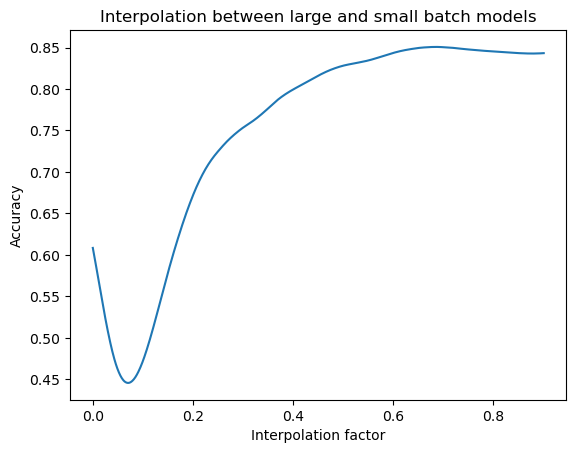

In [49]:
#plot accuracy vs interpolation
# smooth the plot
window_length = 50
accuracies = np.convolve(accuracies, np.ones(window_length)/window_length, mode='valid')
x_steps = x_steps[:len(accuracies)]
plt.plot(x_steps, accuracies)
plt.xlabel('Interpolation factor')
plt.ylabel('Accuracy')
plt.title('Interpolation between large and small batch models')